In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

os.chdir('/Users/wynnephilpott/Documents/missing pauldron/Data Science/datasets')

In [6]:
df = pd.read_csv('dfd.csv')

In [7]:
df.shape

(524, 52)

In [8]:
female = df[df['gender']==0]
male = df[df['gender']==1]

In [9]:
female.columns

Index(['iid', 'id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position',
       'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date',
       'go_out', 'career_c', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'exphappy', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
       'shar1_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1',
       'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1'],
      dtype='object')

In [10]:
f = female.drop(['id', 'gender', 'idg', 'condtn', 'wave', 'round', 'position'],axis=1)

In [11]:
from sklearn.cluster import KMeans

In [12]:
#choose k value
ssd = []
K = range(1,15)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(f)
    ssd.append(km.inertia_)

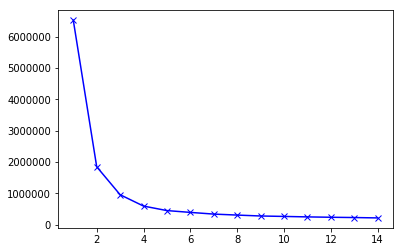

In [15]:
plt.plot(K,ssd,'bx-')

In [16]:
km = KMeans(n_clusters=3)
km.fit(f.drop('iid',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
km.labels_[1:25]

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 0, 1,
       2, 0], dtype=int32)

In [18]:
kmf = pd.Series(km.labels_)
kmf = kmf.to_frame(name='cluster')

In [19]:
iid_kmf = pd.concat([female['iid'].reset_index(drop=True),kmf],axis=1)

In [20]:
iid_kmf.head()

,iid,cluster
0,4,1
1,5,0
2,6,1
3,7,1
4,8,1


In [21]:
score = pd.read_csv('dfs.csv')
female_score = score[score['gender']==0]

In [22]:
dff = pd.merge(iid_kmf,female_score,on='iid',how='inner')

In [23]:
import os

In [18]:
pwd

'/Users/wynnephilpott/Documents/missing pauldron/Data Science/datasets'

In [19]:
os.chdir('/Users/wynnephilpott/Desktop')

In [60]:
dff.to_excel('female_score_km_clusters.xlsx')

**LGM**

In [24]:
df = pd.read_csv('female_score_km_clusters.csv')

In [25]:
cluster1 = df[df['cluster']==0]
cluster2 = df[df['cluster']==1]
cluster3 = df[df['cluster']==2]

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression

In [27]:
lgm = LogisticRegression()

Cluster 1

In [28]:
X = cluster1[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster1['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       327
           1       0.75      0.68      0.71       226

   micro avg       0.77      0.77      0.77       553
   macro avg       0.77      0.76      0.76       553
weighted avg       0.77      0.77      0.77       553

[[275  52]
 [ 73 153]]


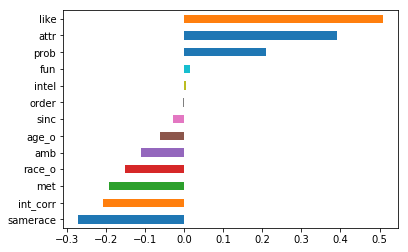

In [30]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

**Customize the Model**

In [31]:
X = cluster1[['like','attr','prob','samerace','int_corr','met','amb']]
y = cluster1['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       327
           1       0.76      0.67      0.71       226

   micro avg       0.78      0.78      0.78       553
   macro avg       0.77      0.76      0.76       553
weighted avg       0.78      0.78      0.77       553

[[279  48]
 [ 75 151]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Removing fileds does not boost f1 score.

Cluster 2

In [37]:
X = cluster2[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster2['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       186
           1       0.64      0.67      0.66       126

   micro avg       0.72      0.72      0.72       312
   macro avg       0.71      0.71      0.71       312
weighted avg       0.72      0.72      0.72       312

[[139  47]
 [ 41  85]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets try customizing this model.

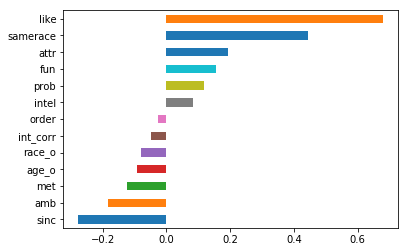

In [34]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

In [36]:
X = cluster2[[
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster2['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       186
           1       0.66      0.68      0.67       126

   micro avg       0.73      0.73      0.73       312
   macro avg       0.72      0.72      0.72       312
weighted avg       0.73      0.73      0.73       312

[[141  45]
 [ 40  86]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 score went up!

Cluster 3

In [36]:
X = cluster3[['order', 'int_corr',
       'samerace', 'age_o', 'race_o','attr',
       'sinc', 'intel', 'fun', 'amb', 'like', 'prob', 'met']]
y = cluster3['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81        41
           1       0.82      0.36      0.50        25

   micro avg       0.73      0.73      0.73        66
   macro avg       0.76      0.66      0.66        66
weighted avg       0.75      0.73      0.69        66

[[39  2]
 [16  9]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


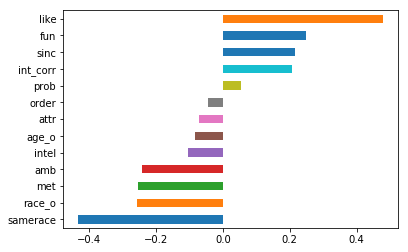

In [34]:
coefficients = lgm.coef_
feature_importance = pd.Series(coefficients[0],
                               index=X.columns)
ordered_feature_importance = feature_importance.sort_values()
ordered_feature_importance.plot.barh()

In [48]:
X = cluster3[['like','fun','sinc','int_corr']]
y = cluster3['dec']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=101)

lgm.fit(X_train,y_train)
pred = lgm.predict(X_test)

print(cr(y_test,pred))
print(cm(y_test,pred))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        41
           1       1.00      0.32      0.48        25

   micro avg       0.74      0.74      0.74        66
   macro avg       0.85      0.66      0.66        66
weighted avg       0.82      0.74      0.70        66

[[41  0]
 [17  8]]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 went up slightly though we lost 1 true positive

Overall 247 'yes's were classified correctly compared to the 203 from LGM alone.